# Fake News Classification with CNN and CNN-LSTM 

In [1]:
#Normal Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from tensorflow import keras as k

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Activation, BatchNormalization, LSTM, TimeDistributed
from keras.layers import Concatenate, Conv2D, MaxPooling2D, GRU
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding

import tensorflow as tf
from textblob import TextBlob
from collections import Counter
from keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics


def read_pairs(path, separator='\t', cast=(str, str), offset=0):
    with open(path) as f:
        return [(cast[0](k), cast[1](v)) for line in f.readlines()[offset:] for k, v in [line.rstrip().split(separator)]]


### Importing the dataset

In [2]:
test_path = "../data/final/test.csv"

raw_data_test = dict(read_pairs(test_path, cast=(int,str), offset=1))
data_test = {
    'id': pd.Index(list(raw_data_test.keys())),
    'text': pd.Index(list(raw_data_test.values()))
}

test = pd.DataFrame(data_test)

In [3]:
train = pd.read_csv("../data/final/data_cleaned.csv")

In [4]:
train.head()

,label,text,sent,lexical_diver,use_super,len_exclaim,len_question,first_person
0,1,get the latest from today sign up for our news...,0.1531,0.537662,1,0,0,8
1,1,2d conan on the funeral trump will be invited...,-0.3612,0.857143,0,0,0,0
2,0,it’s safe to say that instagram stories has fa...,0.9879,0.536862,1,6,2,5
3,0,much like a certain amazon goddess with a lass...,0.9992,0.348816,5,2,2,32
4,0,at a time when the perfect outfit is just one ...,0.7234,0.682927,0,0,0,0


In [5]:
test.head()

,id,text
0,2,The 2017 Teen Choice Awards ceremony was held ...
1,3,"The concert, part of “The Joshua Tree Tour,” w..."
2,4,Selena Gomez refuses to talk to her mother abo...
3,5,This is worse than a lump of coal in your stoc...
4,6,Luann De Lesseps is going to rehab after her a...


### Preprocessing for test dataset

## Creation of Handpicked Features


During our consultation, we felt that there may be additional features that we may find interesting and we would want to feed into our model. These include:

* The average length of words in a sentence in the text
* The number of exclamations
* The number of superlatives in the text
* The classification result of the title

In [6]:
## Auxillary functions

#Counts the words that are in first person
def count_person_forms(text, person):
    text = tokenize(text.lower())
    counter = 0
    for word in text:
        if word in person:
            counter += 1
    return counter

#Sentiment analysis using vader sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

def classify_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    text = text.replace("\n\n", ". ").replace("\n", ". ")
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    pol = sid.polarity_scores(text)['compound']
    return pol

#Count the lexical diversity of the text
def lexical_diversity(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = tokenize(text.lower())
    if len(text) == 0:
        return 0
    return len(set(text)) / len(text)

def percentage(count, total):
    return 100 * count / total

#Counts the number of superlatives in the text
from textblob import TextBlob

def textblob_adj(text):
    blobed = TextBlob(text)
    counts = Counter(tag for word,tag in blobed.tags)
    super_list = []
    super_tag_list = ['JJS','RBS']
    for (a, b) in blobed.tags:
        if b in super_tag_list:
           super_list.append(a)
    return counts['JJS'] + counts['RBS']

def list_superlatives(text):
    add_list = []
    for txt in text:
        add_list.append(textblob_adj(txt))
    return add_list

from nltk.tokenize import RegexpTokenizer
def tokenize(text):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    return tokens

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chengling/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
test['sent'] = test.apply(lambda r: classify_sentiment(r['text']), axis=1)

test['lexical_diver'] = test.apply(lambda r: lexical_diversity(r['text']), axis=1)

test = test.assign(use_super = list_superlatives(test.text))

test['len_exclaim'] = test.text.str.count("!")
test['len_question']= test.text.str.count("\?")

first_person = ["i", "me", "mine", "we", "us", "our", "ours"]
test['first_person'] = test.apply(lambda row: count_person_forms(row['text'], first_person), axis=1)

test["text"] = test["text"].str.lower()

In [8]:
test.head()

,id,text,sent,lexical_diver,use_super,len_exclaim,len_question,first_person
0,2,the 2017 teen choice awards ceremony was held ...,0.9360,0.559471,0,0,0,0
1,3,"the concert, part of “the joshua tree tour,” w...",-0.9807,0.489960,0,2,2,11
2,4,selena gomez refuses to talk to her mother abo...,0.9917,0.450135,0,1,0,2
3,5,this is worse than a lump of coal in your stoc...,0.9876,0.465979,0,1,2,1
4,6,luann de lesseps is going to rehab after her a...,0.9563,0.613718,1,0,0,5


## Padding and embedding the data

We use the GloVe embeddings...

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.text)

#tokenizing by word, maybe can think of way to tokenize by sentence
word_index = tokenizer.word_index
vocab_size = len(word_index)

print(vocab_size)

83790


In [10]:
#padding data 

sequences = tokenizer.texts_to_sequences(train.text)
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')


In [11]:
embeddings_index = {}
with open('../experimental/rnn/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector


100


In [12]:
latent_train = train.iloc[0:,2:]

In [13]:
x_train,x_test,new_train,new_test,y_train,y_test = train_test_split(padded,latent_train,train.label,test_size = 0.2,random_state = 42)

print('Shape of training data: ') #number of dimension in the array
print(x_train.shape) 
print(y_train.shape)
print('Shape of test data: ') #number of dimension in the array
print(x_test.shape)
print(y_test.shape)
print('Shape of latent data: ') #number of dimension in the array
print(new_train.shape)
print(new_test.shape)

Shape of training data: 
(3784, 500)
(3784,)
Shape of test data: 
(947, 500)
(947,)
Shape of latent data: 
(3784, 6)
(947, 6)


### Tokenizing and embedding of test data

In [14]:
test["text"] = test.text.str.lower()

tokenizer_test = Tokenizer()
tokenizer_test.fit_on_texts(test.text)

#tokenizing by word, maybe can think of way to tokenize by sentence
word_index_test = tokenizer_test.word_index
vocab_size_test = len(word_index_test)

print(vocab_size_test)

40295


In [15]:
#padding data 

sequences_test = tokenizer_test.texts_to_sequences(test.text)
padded_test = pad_sequences(sequences_test, maxlen=500, padding='post', truncating='post')

In [16]:
embeddings_index_test = {}
with open('../experimental/rnn/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index_test[word] = coefs
print(len(coefs))

embeddings_matrix_test = np.zeros((vocab_size_test+1, 100))
for word, i in word_index_test.items():
    embedding_vector = embeddings_index_test.get(word)
    if embedding_vector is not None:
        embeddings_matrix_test[i] = embedding_vector

100


In [17]:
latent_test = test.iloc[0:,2:]

## CNN Model

In this first test, we will create our CNN model without our additional features 

In [18]:
model = Sequential()
model.add(Embedding(vocab_size+1, 100, input_length=500))

model.add(Conv1D(filters=80, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(150,activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          8379100   
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 80)           24080     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 249, 80)           0         
_________________________________________________________________
dropout (Dropout)            (None, 249, 80)           0         
_________________________________________________________________
flatten (Flatten)            (None, 19920)             0         
_________________________________________________________________
dense (Dense)                (None, 150)               2988150   
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0

In [19]:
model.compile(k.optimizers.Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(k.optimizers.SGD(lr=0.1, momentum = 0.1), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          8379100   
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 80)           24080     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 249, 80)           0         
_________________________________________________________________
dropout (Dropout)            (None, 249, 80)           0         
_________________________________________________________________
flatten (Flatten)            (None, 19920)             0         
_________________________________________________________________
dense (Dense)                (None, 150)               2988150   
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0

In [20]:
history = model.fit(x_train, y_train, epochs=20, batch_size=100, validation_data=(x_test, y_test),callbacks = [k.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, min_delta = 0.01)])

Epoch 1/20
38/38 [==============================] - 11s 296ms/step - loss: 0.6757 - accuracy: 0.5928 - val_loss: 0.6662 - val_accuracy: 0.6072
Epoch 2/20
38/38 [==============================] - 11s 287ms/step - loss: 0.6249 - accuracy: 0.6424 - val_loss: 0.6410 - val_accuracy: 0.6663
Epoch 3/20
38/38 [==============================] - 11s 292ms/step - loss: 0.4276 - accuracy: 0.8348 - val_loss: 0.5218 - val_accuracy: 0.7656
Epoch 4/20
38/38 [==============================] - 11s 283ms/step - loss: 0.1594 - accuracy: 0.9516 - val_loss: 0.4978 - val_accuracy: 0.7846
Epoch 5/20
38/38 [==============================] - 11s 283ms/step - loss: 0.0525 - accuracy: 0.9921 - val_loss: 0.5967 - val_accuracy: 0.7804
Epoch 6/20
38/38 [==============================] - 12s 305ms/step - loss: 0.0279 - accuracy: 0.9966 - val_loss: 0.6522 - val_accuracy: 0.7656


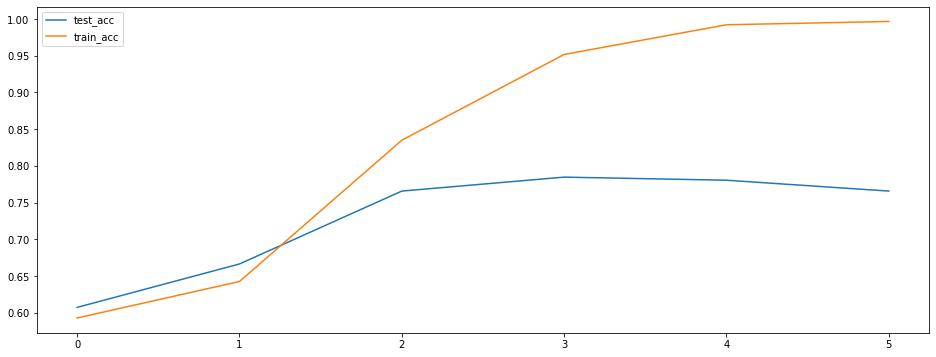

In [21]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.plot(history.history['accuracy'], label='train_acc')
plt.legend()

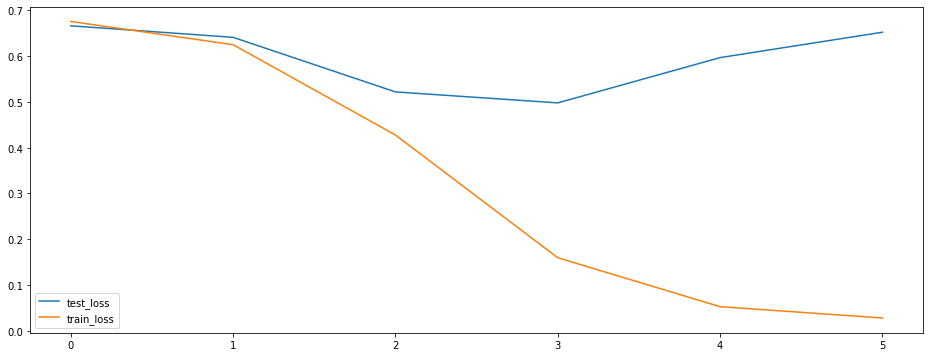

In [22]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='test_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

In [23]:
test_pred = model.predict(x_test)
accuracy_score(y_test, test_pred.round())

0.7655755015839493

In [24]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       575
           1       0.69      0.74      0.71       372

    accuracy                           0.77       947
   macro avg       0.76      0.76      0.76       947
weighted avg       0.77      0.77      0.77       947



[[450 125]
 [ 97 275]]


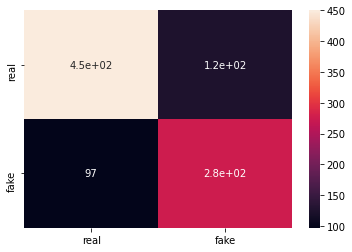

In [25]:
matrix = confusion_matrix(y_test, test_pred.round())
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['real','fake'], index=['real', 'fake'])
sns.heatmap(df_cm, annot=True)

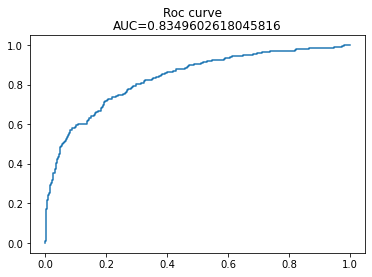

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
auc = metrics.roc_auc_score(y_test, test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')
ax.plot(fpr,tpr)

In [27]:
test_pred1 = model.predict(padded_test)
test1 = test.copy()
test1["label"] = test_pred1
for i in range(len(test1)):
    if test1.label[i] <0.5:
        test1.label[i] = 0 
    else:
        test1.label[i] = 1

<ipython-input-27-9c799c06e6f7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1.label[i] = 1
<ipython-input-27-9c799c06e6f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1.label[i] = 0


## CNN Model with additional latent features

In [28]:
## two shapes of inputs
input_1 = Input(shape=(500,))
input_2 = Input(shape=(6,))

##Text layer
embedding_layer = Embedding(vocab_size+1, 100, weights=[embeddings_matrix])(input_1)
conv1_layer1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding_layer)
pool_layer1 = MaxPooling1D(pool_size=4)(conv1_layer1)

conv1_layer2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_layer1)
pool_layer2 = MaxPooling1D(pool_size=4)(conv1_layer2)

conv1_layer3 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool_layer2)
pool_layer3 = MaxPooling1D(pool_size=4)(conv1_layer3)

flat_layer = Flatten()(pool_layer3)

## Latent Features Layer
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

#Combining layers
concat_layer = Concatenate()([flat_layer, dense_layer_2])
dense_layer_3 = Dense(128, activation='relu')(concat_layer)

dense_layer_4 = Dense(10, activation='relu')(dense_layer_3)

output = Dense(1, activation='sigmoid')(dense_layer_4)
model = Model(inputs=[input_1, input_2], outputs=output)


In [29]:
model.compile(k.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(k.optimizers.SGD(lr=0.1, momentum = 0.1), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 100)     8379100     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 498, 32)      9632        embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 124, 32)      0           conv1d_1[0][0]                   
_______________________________________________________________________________________

In [30]:
history = model.fit([x_train,new_train], y_train, epochs=30, batch_size=100, validation_data=([x_test,new_test], y_test),callbacks = [k.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta = 0.01)])

Epoch 1/30
38/38 [==============================] - 10s 270ms/step - loss: 0.6737 - accuracy: 0.6054 - val_loss: 0.6677 - val_accuracy: 0.6082
Epoch 2/30
38/38 [==============================] - 10s 259ms/step - loss: 0.6591 - accuracy: 0.6113 - val_loss: 0.6652 - val_accuracy: 0.6199
Epoch 3/30
38/38 [==============================] - 9s 239ms/step - loss: 0.6481 - accuracy: 0.6316 - val_loss: 0.6547 - val_accuracy: 0.6283
Epoch 4/30
38/38 [==============================] - 8s 220ms/step - loss: 0.6360 - accuracy: 0.6525 - val_loss: 0.6489 - val_accuracy: 0.6315
Epoch 5/30
38/38 [==============================] - 8s 219ms/step - loss: 0.6215 - accuracy: 0.6609 - val_loss: 0.6437 - val_accuracy: 0.6251
Epoch 6/30
38/38 [==============================] - 9s 239ms/step - loss: 0.6099 - accuracy: 0.6697 - val_loss: 0.6471 - val_accuracy: 0.6251
Epoch 7/30
38/38 [==============================] - 9s 225ms/step - loss: 0.5894 - accuracy: 0.6934 - val_loss: 0.6222 - val_accuracy: 0.6536
Epoc

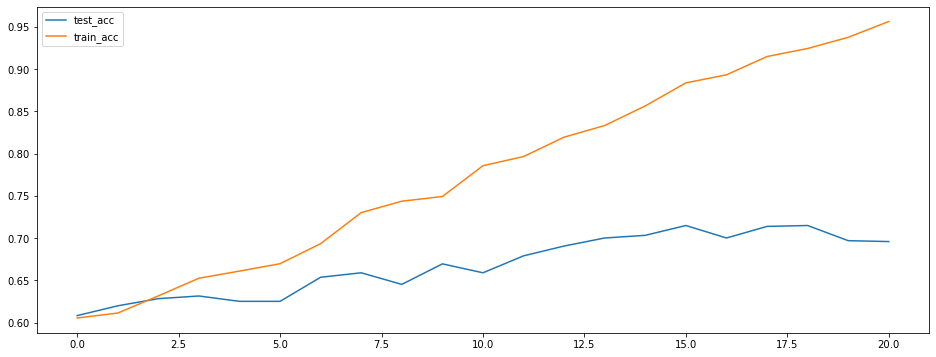

In [31]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.plot(history.history['accuracy'], label='train_acc')
plt.legend()

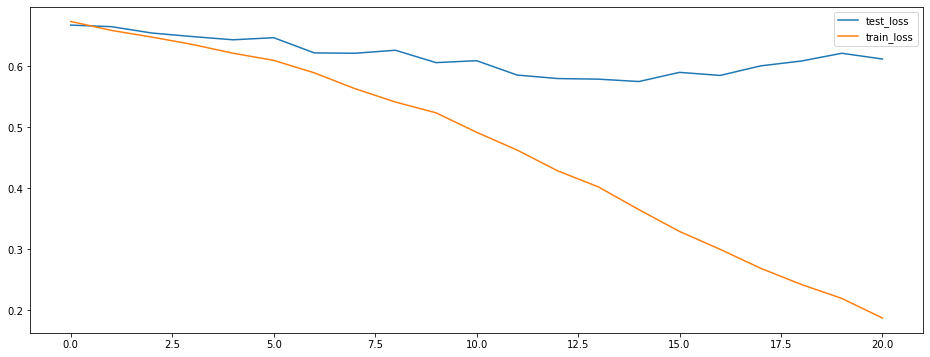

In [32]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='test_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

In [33]:
test_pred = model.predict([x_test,new_test])
accuracy_score(y_test, test_pred.round())

0.6958817317845829

In [34]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       575
           1       0.61      0.61      0.61       372

    accuracy                           0.70       947
   macro avg       0.68      0.68      0.68       947
weighted avg       0.70      0.70      0.70       947



[[432 143]
 [145 227]]


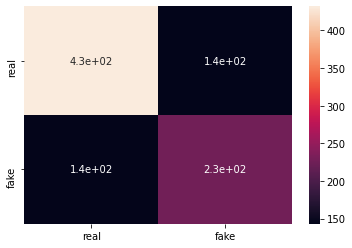

In [35]:
matrix = confusion_matrix(y_test, test_pred.round())
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['real','fake'], index=['real', 'fake'])
sns.heatmap(df_cm, annot=True)

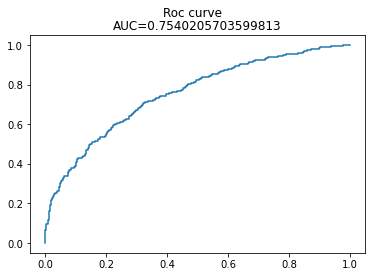

In [36]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
auc = metrics.roc_auc_score(y_test, test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')
ax.plot(fpr,tpr)

In [38]:
test_pred2 = model.predict([padded_test,latent_test])
test2 = test.copy()
test2["label"] = test_pred2
for i in range(len(test2)):
    if test2.label[i] <0.5:
        test2.label[i] = 0 
    else:
        test2.label[i] = 1

<ipython-input-38-fef08fdb7f6e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2.label[i] = 0
<ipython-input-38-fef08fdb7f6e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2.label[i] = 1


## CNN-GRU Model

In [39]:
model = Sequential()
model.add(Embedding(vocab_size+1, 100, input_length=500))
model.add(Conv1D(32,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.35))
model.add(Conv1D(128,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))
model.add(GRU(50,return_sequences=True))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          8379100   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 500, 32)           9632      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 250, 64)           6208      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 125, 64)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 125, 64)          

In [40]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          8379100   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 500, 32)           9632      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 250, 64)           6208      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 125, 64)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 125, 64)          

In [41]:
history = model.fit(x_train, y_train, epochs=20, batch_size=100, validation_data=(x_test, y_test),callbacks = [k.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, min_delta = 0.01)])

Epoch 1/20
38/38 [==============================] - 18s 482ms/step - loss: 0.6736 - accuracy: 0.6039 - val_loss: 0.6787 - val_accuracy: 0.6072
Epoch 2/20
38/38 [==============================] - 18s 485ms/step - loss: 0.6146 - accuracy: 0.6554 - val_loss: 0.5005 - val_accuracy: 0.7582
Epoch 3/20
38/38 [==============================] - 15s 399ms/step - loss: 0.3290 - accuracy: 0.8626 - val_loss: 0.5189 - val_accuracy: 0.7423
Epoch 4/20
38/38 [==============================] - 16s 430ms/step - loss: 0.0963 - accuracy: 0.9656 - val_loss: 0.7614 - val_accuracy: 0.7244


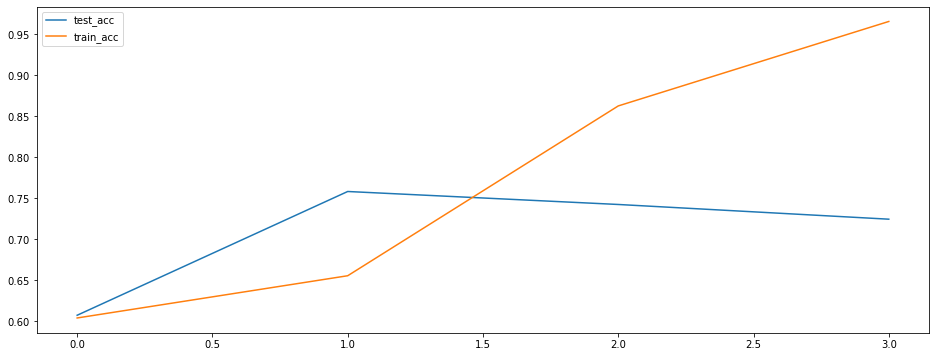

In [42]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.plot(history.history['accuracy'], label='train_acc')
plt.legend()

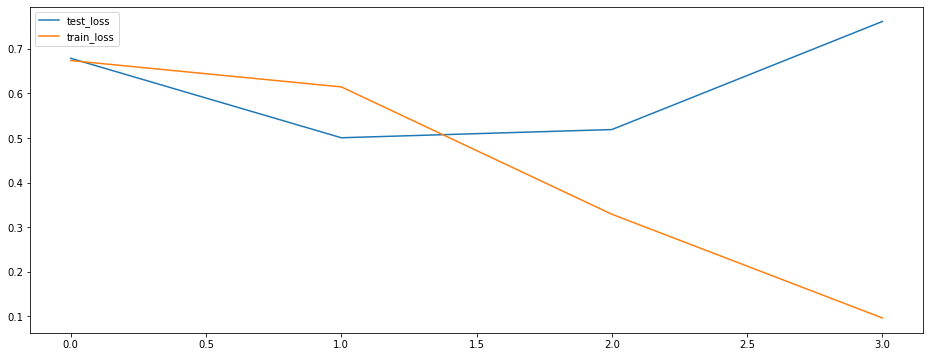

In [43]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='test_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

In [44]:
test_pred = model.predict(x_test)
accuracy_score(y_test, test_pred.round())

0.7243928194297783

In [45]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       575
           1       0.69      0.55      0.61       372

    accuracy                           0.72       947
   macro avg       0.71      0.69      0.70       947
weighted avg       0.72      0.72      0.72       947



[[483  92]
 [169 203]]


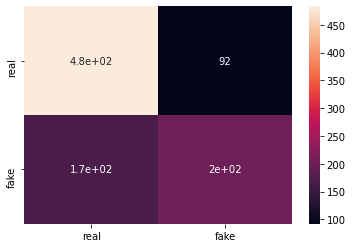

In [46]:
matrix = confusion_matrix(y_test, test_pred.round())
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['real','fake'], index=['real', 'fake'])
sns.heatmap(df_cm, annot=True)

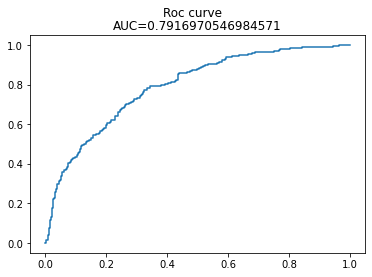

In [47]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
auc = metrics.roc_auc_score(y_test, test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')
ax.plot(fpr,tpr)

In [49]:
test_pred3 = model.predict(padded_test)
test3 = test.copy()
test3["label"] = test_pred3
for i in range(len(test3)):
    if test3.label[i] <0.5:
        test3.label[i] = 0 
    else:
        test3.label[i] = 1

<ipython-input-49-31c01be3e6db>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3.label[i] = 0
<ipython-input-49-31c01be3e6db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3.label[i] = 1


## CNN-GRU Model with additional latent features

In [50]:
## two shapes of inputs
input_1 = Input(shape=(500,))
input_2 = Input(shape=(6,))

##Text layer
embedding_layer = Embedding(vocab_size+1, 100, weights=[embeddings_matrix])(input_1)
conv1_layer1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding_layer)
pool_layer1 = MaxPooling1D(pool_size=4)(conv1_layer1)
drop1 = Dropout(0.3)(pool_layer1)

conv1_layer2 = Conv1D(filters=64, kernel_size=3, activation='relu')(drop1)
pool_layer2 = MaxPooling1D(pool_size=4)(conv1_layer2)
drop2 = Dropout(0.35)(pool_layer2)

conv1_layer3 = Conv1D(filters=128, kernel_size=3, activation='relu')(drop2)
pool_layer3 = MaxPooling1D(pool_size=4)(conv1_layer3)
drop3 = Dropout(0.4)(pool_layer3)

GRU1 = GRU(50,return_sequences=True)(drop3)
drop4 = Dropout(0.25)(GRU1)

flat_layer = Flatten()(drop4)

## Latent Features Layer
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

#Combining layers
concat_layer = Concatenate()([flat_layer, dense_layer_2])
dense_layer_3 = Dense(128, activation='relu')(concat_layer)

dense_layer_4 = Dense(10, activation='relu')(dense_layer_3)

output = Dense(1, activation='sigmoid')(dense_layer_4)
model = Model(inputs=[input_1, input_2], outputs=output)


In [51]:
model.compile(k.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(k.optimizers.SGD(lr=0.1, momentum = 0.1), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 500, 100)     8379100     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 498, 32)      9632        embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 124, 32)      0           conv1d_7[0][0]                   
_______________________________________________________________________________________

In [52]:
history = model.fit([x_train,new_train], y_train, epochs=30, batch_size=100, validation_data=([x_test,new_test], y_test),callbacks = [k.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta = 0.01)])

Epoch 1/30
38/38 [==============================] - 17s 440ms/step - loss: 0.6804 - accuracy: 0.5914 - val_loss: 0.6698 - val_accuracy: 0.6072
Epoch 2/30
38/38 [==============================] - 15s 402ms/step - loss: 0.6717 - accuracy: 0.6065 - val_loss: 0.6645 - val_accuracy: 0.6072
Epoch 3/30
38/38 [==============================] - 15s 393ms/step - loss: 0.6717 - accuracy: 0.6052 - val_loss: 0.6626 - val_accuracy: 0.6072
Epoch 4/30
38/38 [==============================] - 13s 333ms/step - loss: 0.6582 - accuracy: 0.6084 - val_loss: 0.6547 - val_accuracy: 0.6125
Epoch 5/30
38/38 [==============================] - 11s 290ms/step - loss: 0.6301 - accuracy: 0.6446 - val_loss: 0.6038 - val_accuracy: 0.6885
Epoch 6/30
38/38 [==============================] - 10s 275ms/step - loss: 0.5342 - accuracy: 0.7376 - val_loss: 0.5296 - val_accuracy: 0.7550
Epoch 7/30
38/38 [==============================] - 13s 331ms/step - loss: 0.4162 - accuracy: 0.8147 - val_loss: 0.5155 - val_accuracy: 0.7487

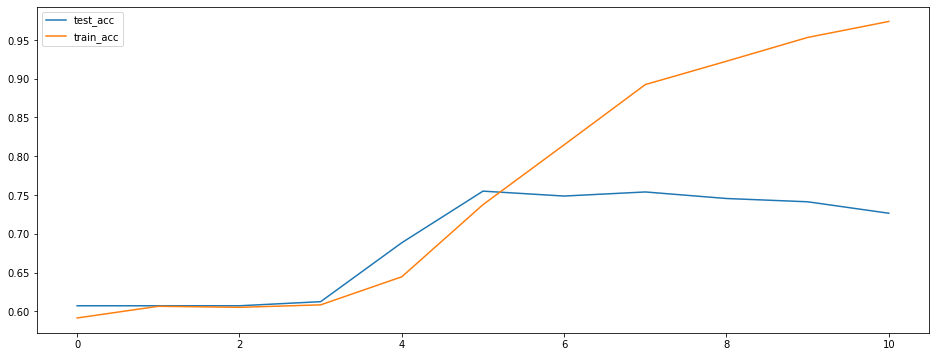

In [53]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.plot(history.history['accuracy'], label='train_acc')
plt.legend()

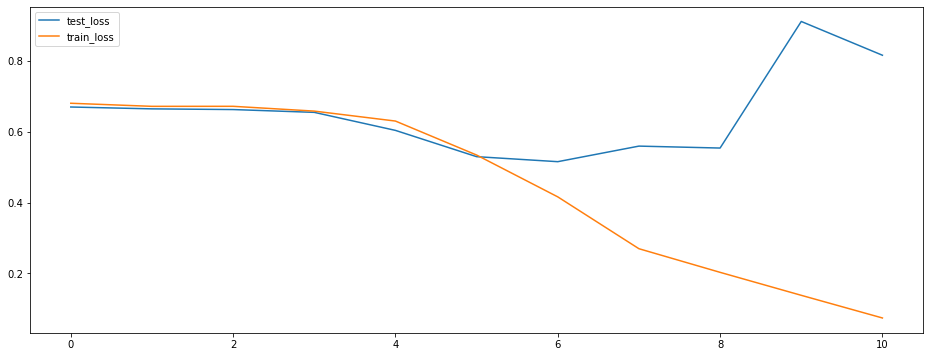

In [54]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='test_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

In [55]:
test_pred = model.predict([x_test,new_test])
accuracy_score(y_test, test_pred.round())

0.7265047518479408

In [56]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.78      0.77      0.77       575
           1       0.65      0.66      0.65       372

    accuracy                           0.73       947
   macro avg       0.71      0.71      0.71       947
weighted avg       0.73      0.73      0.73       947



[[444 131]
 [128 244]]


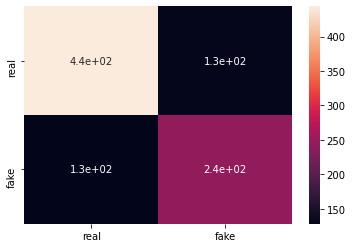

In [57]:
matrix = confusion_matrix(y_test, test_pred.round())
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['real','fake'], index=['real', 'fake'])
sns.heatmap(df_cm, annot=True)

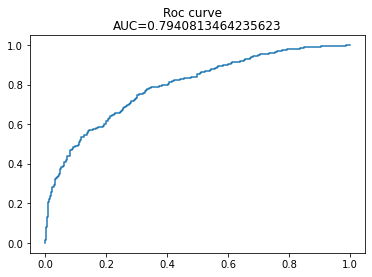

In [59]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
auc = metrics.roc_auc_score(y_test, test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')
ax.plot(fpr,tpr)

In [61]:
test_pred4 = model.predict([padded_test,latent_test])
test4 = test.copy()
test4["label"] = test_pred4
for i in range(len(test4)):
    if test4.label[i] <0.5:
        test4.label[i] = 0 
    else:
        test4.label[i] = 1

<ipython-input-61-c87f3d1be2f2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test4.label[i] = 1
<ipython-input-61-c87f3d1be2f2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test4.label[i] = 0


## Saving all the files

In [ ]:
submission1= test1[["id","label"]].copy()
submission1["label"] = submission1.label.astype("int")
filename = 'submission1.csv'
submission1.to_csv(filename,index=False)

In [ ]:
submission2= test2[["id","label"]].copy()
submission2["label"] = submission2.label.astype("int")
filename = 'submission2.csv'
submission2.to_csv(filename,index=False)

In [ ]:
submission3= test3[["id","label"]].copy()
submission3["label"] = submission3.label.astype("int")
filename = 'submission3.csv'
submission3.to_csv(filename,index=False)

In [ ]:
submission4= test4[["id","label"]].copy()
submission4["label"] = submission4.label.astype("int")
filename4 = 'submission4.csv'
submission4.to_csv(filename4,index=False)